# Lab03 Part 2: Processing the Data

By Rob Hendrickson

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
# import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

# Silence warnings
import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
# Load data

temps = pd.read_csv('temps_raw.csv')

temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station Name   4230 non-null   object 
 1   Latitude       4230 non-null   float64
 2   Longitude      4230 non-null   float64
 3   Elevation      4230 non-null   int64  
 4   Year           4230 non-null   float64
 5   Month          4230 non-null   float64
 6   Day            4230 non-null   float64
 7   Max Temp       4230 non-null   float64
 8   Max Temp Flag  14 non-null     object 
 9   Min Temp       4230 non-null   float64
 10  Min Temp Flag  16 non-null     object 
 11  Avg Temp       4230 non-null   float64
 12  Avg Temp Flag  16 non-null     object 
dtypes: float64(8), int64(1), object(4)
memory usage: 429.7+ KB


In [3]:
# Check the flag columns for unique values

print(temps['Max Temp Flag'].unique())

print(temps['Min Temp Flag'].unique())

print(temps['Avg Temp Flag'].unique())

[nan 'E']
[nan 'E']
[nan 'E']


In [4]:
# What does E mean? 
# ERROR!?

error_data = temps[(temps['Avg Temp Flag'] == 'E') |
                       (temps['Max Temp Flag'] == 'E') | 
                      (temps['Min Temp Flag'] == 'E')]

error_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 66 to 3156
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station Name   16 non-null     object 
 1   Latitude       16 non-null     float64
 2   Longitude      16 non-null     float64
 3   Elevation      16 non-null     int64  
 4   Year           16 non-null     float64
 5   Month          16 non-null     float64
 6   Day            16 non-null     float64
 7   Max Temp       16 non-null     float64
 8   Max Temp Flag  14 non-null     object 
 9   Min Temp       16 non-null     float64
 10  Min Temp Flag  16 non-null     object 
 11  Avg Temp       16 non-null     float64
 12  Avg Temp Flag  16 non-null     object 
dtypes: float64(8), int64(1), object(4)
memory usage: 1.8+ KB


In [16]:
print(f'''Notes: 

# There were {len(error_data.Day)} errors. 

On these unique days:

{error_data.Day.unique()}

At these stations:

{error_data['Station Name'].unique()}
''')

Notes: 

# There were 16 errors. 

On these unique days:

[19. 13. 15. 16. 11. 14.  1.]

At these stations:

['Alamo' 'Becker' 'Brorson' 'Cavalier' 'Crary' 'Epping' 'Jamestown'
 'Langdon' 'Mayville' 'Medicine Hole' 'Pine Point' 'Plaza' 'Rat Lake']



In [6]:
error_data[['Year', 'Month', 'Day', 'Station Name']]

,Year,Month,Day,Station Name
66,2022.0,11.0,19.0,Alamo
270,2022.0,11.0,13.0,Becker
272,2022.0,11.0,15.0,Becker
273,2022.0,11.0,16.0,Becker
478,2022.0,12.0,11.0,Brorson
606,2022.0,11.0,19.0,Cavalier
816,2022.0,11.0,19.0,Crary
1266,2022.0,11.0,19.0,Epping
2076,2022.0,11.0,19.0,Jamestown
2190,2022.0,11.0,13.0,Langdon


In [7]:
# Hmmm, well. At least we're just doing the monthly average

# So these data must be removed

clean_data = temps[~(temps['Avg Temp Flag'] == 'E') &
                       ~(temps['Max Temp Flag'] == 'E') & 
                       ~(temps['Min Temp Flag'] == 'E')]

In [8]:
# Hope that's okay? Now on to averaging the past month

# Grouping by station

# Columns for stats
stat_cols = ['Max Temp', 'Min Temp', 'Avg Temp']
# Columns for station information
station_cols = ['Station Name', 'Latitude', 'Longitude', 'Elevation']

stats_data = clean_data[station_cols + stat_cols]

# Group by Station Name

mean_data = stats_data.groupby(station_cols).mean().reset_index()

mean_data.head()

,Station Name,Latitude,Longitude,Elevation,Max Temp,Min Temp,Avg Temp
0,Ada,47.321190,-96.514060,910,26.010333,10.750433,18.380600
1,Adams,48.499880,-98.075880,1580,21.879300,6.083133,13.981400
2,Alamo,48.546520,-103.471860,2157,22.563379,4.557828,13.560793
3,Alvarado,48.245942,-97.021532,809,23.928267,7.804167,15.866500
4,Amidon,46.488440,-103.316290,2882,28.610433,9.722800,19.166867


In [9]:
# Transform into UTM coords (NAD83, utm zone 14N)

# Spatialize

temps_gdf = gpd.GeoDataFrame(mean_data,
                             geometry = gpd.points_from_xy(x = mean_data.Longitude,
                                                           y = mean_data.Latitude),
                             crs = 'EPSG:4326')

# Transform

temps_utm = temps_gdf.to_crs('EPSG:26914')

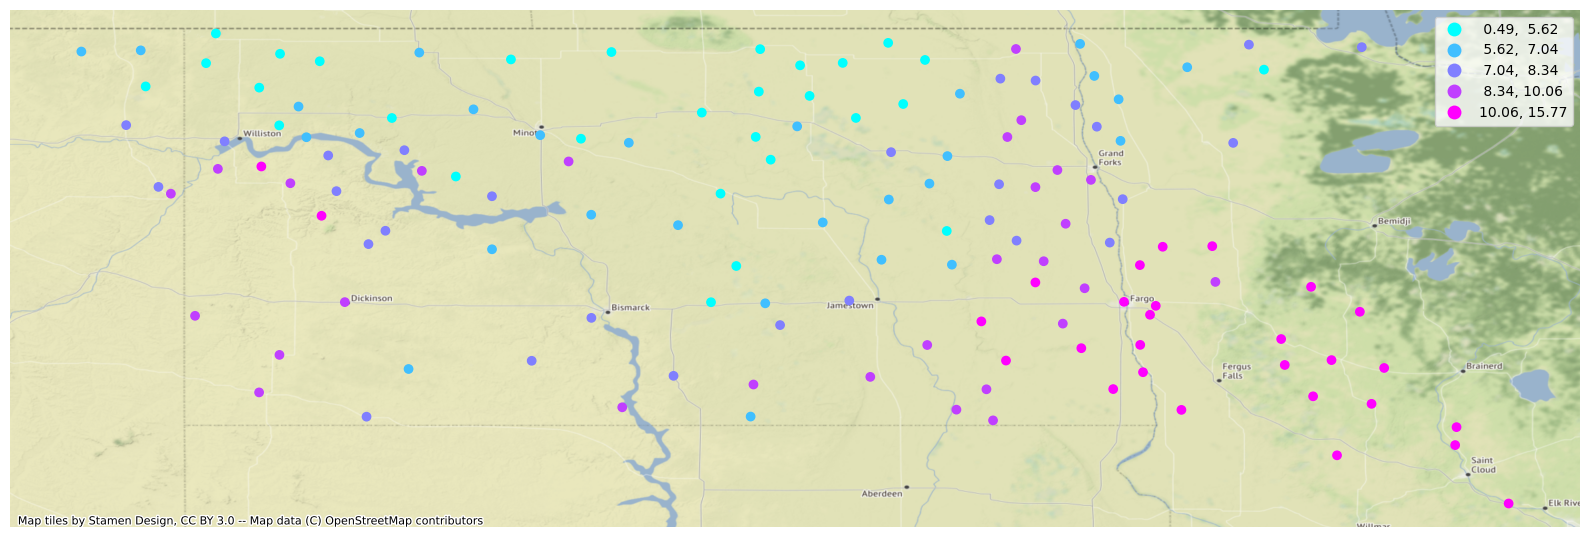

In [19]:
# Verification 

f, ax = plt.subplots(1,1,figsize = (16,8))

temps_gdf.plot('Min Temp', cmap = 'cool',k=5,
                       scheme = 'quantiles', 
               legend = True,
               ax = ax)

contextily.add_basemap(ax = ax,
                       crs = temps_gdf.crs)#,
                       # source = contextily.providers.CartoDB.Positron)
                     
        
     
          
ax.set_axis_off()
plt.tight_layout()

plt.savefig(os.path.join(os.getcwd(), 'LaTeX', 'figs', 'AvgMinTempPts.png'), dpi = 100)


In [13]:
# Save

# As a geojson
# A little bigger in size (45.8kB vs 14.4kB)
# but more convenient in Arc because it has CRS

# Create utm coords column

temps_utm['X'] = temps_utm.geometry.x
temps_utm['Y'] = temps_utm.geometry.y

# Get relevant columns for csv

cols = ['Station Name', 'Elevation', 'Max Temp', 'Min Temp',
       'Avg Temp', 'X', 'Y', 'geometry']

temps_utm[cols].to_file('temps.geojson')

In [14]:
# As a CSV (If we were going with the scipy route)

# Get relevant columns for csv

cols = ['Station Name', 'Elevation', 'Max Temp', 'Min Temp',
       'Avg Temp', 'X', 'Y']

# Save as csv

temps_utm[cols].to_csv('temps.csv')